### Imports + utility functions

In [1]:
%matplotlib inline

import os
import geopandas as gpd
import numpy as np
import pyproj
from shapely.ops import transform
from shapely.geometry import box
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pystac_client import Client

In [2]:
def get_bbox(geojson_path):
    """Extracts bounding box coordinates from an input vector data file"""
    gdf = gpd.read_file(geojson_path)
    if gdf.crs.to_epsg() != 4326:
        gdf = gdf.to_crs(4326)
    bbox = tuple([float(b) for b in gdf.total_bounds])

    return bbox

### Work through STAC catalog to find product URLs on S3

In [3]:
# Use City of Ottawa urban boundary as test AOI
geojson_path = './ottawa_urban_boundary.geojson'
aoi_gdf = gpd.read_file(geojson_path)
utm_crs = aoi_gdf.estimate_utm_crs().to_epsg()  # required for stackstac call
bbox = get_bbox(geojson_path)

In [4]:
# Filter assets by imaging date
start_date = '2025-04-01'
end_date = '2025-05-01'

In [5]:
# List all RCM-ARD items in EODMS STAC collection that intersect with area of interest and date range
cat_url = 'https://www.eodms-sgdot.nrcan-rncan.gc.ca/stac/'
catalog = Client.open(cat_url)
search = catalog.search(
    collections=['rcm-ard'],
    bbox=bbox,
    datetime=f'{start_date}/{end_date}',
    limit=100
)

items = search.item_collection()
print(f'{len(items)} products found')

6 products found


In [6]:
# Get S3 URLs for all cloud-optimized GeoTIFFs needed for M-Chi decomposition
ard_product = items[0]  # working with a single product for now
order_key = ard_product.properties['order_key']
rl_url, rr_url, rrrl_url = ard_product.assets['rl'].href, ard_product.assets['rr'].href, ard_product.assets['rrrl'].href
rl_url, rr_url, rrrl_url

('https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/04/12/RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_CH_CV_MLC/RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_RL.tif',
 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/04/12/RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_CH_CV_MLC/RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_RR.tif',
 'https://rcm-ceos-ard.s3.ca-central-1.amazonaws.com/MLC/2025/04/12/RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_CH_CV_MLC/RCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_RRRL.tif')

#### Read data from COGs using City of Ottawa spatial subset

RRRL GeoTiff contains 2 bands (real + imaginary) so we define our own read function instead of using stackstac, which only supports single-band rasters

In [7]:
def read_cog_from_bbox(cog_url, bbox=None):
    with rxr.open_rasterio(cog_url) as rds:
        # Reproject bounding box to match raster CRS
        if bbox is None:
            out_cog = rds.copy()
        else:
            bbox_geom = box(*bbox)
            cog_epsg = rds.rio.crs.to_epsg()
        
            project = pyproj.Transformer.from_proj(
                pyproj.Proj('epsg:4326'),  # hard-coded in get_bbox() function 
                pyproj.Proj(f'epsg:{cog_epsg}'),
                always_xy = True) 
            
            # Clip COG to reprojected bounds if provided and return
            bbox_geom_proj = transform(project.transform, bbox_geom)
            out_cog = rds.rio.clip_box(*bbox_geom_proj.bounds)
    
    return out_cog

### M-Chi Decomposition

#### Step 1: convert MLC rasters from RCM-ARD product to Stokes parameters

In [8]:
# Option to process entire product extent or subset by bbox
def ard_to_stokes(rl_url, rr_url, rrrl_url, bbox=None):
    rl, rr, rrrl =  read_cog_from_bbox(rl_url, bbox), read_cog_from_bbox(rr_url, bbox), read_cog_from_bbox(rrrl_url, bbox)
    I = rl + rr
    Q = 2 * rrrl[1, :, :]  # 2nd band is imaginary component
    U = 2 * rrrl[0, :, :]  # 1st band is real component
    V = rl - rr

    return I[0], Q, U, V[0]  # drop redundant "band" dimension

In [9]:
I, Q, U, V = ard_to_stokes(rl_url, rr_url, rrrl_url, bbox=bbox)

#### Step 2: convert Stokes parameters to polarimetric discriminators

In [10]:
def stokes_to_pol(I, Q, U, V):
    dpol = np.sqrt(Q**2 + U**2 + V**2) / I
    chi = V / (dpol * I)

    return dpol, chi

In [11]:
dpol, chi = stokes_to_pol(I, Q, U, V)

#### Step 3: convert polarimetric discriminators to M-Chi feature decomposition

In [12]:
def pol_to_mchi(I, dpol, chi):
    single = I * dpol * (1 + chi) / 2
    volume = I * (1 - dpol)
    double = I * dpol * (1 - chi) / 2

    return single, volume, double

In [13]:
single, volume, double = pol_to_mchi(I, dpol, chi)

#### Visualize results and save to disk

In [14]:
mchi_stack = xr.concat([double, volume, single], dim='band')
mchi_stack.coords['band'] = [0, 1, 2]
mchi_stack.attrs['long_name'] = ['Double-bounce scattering', 'Volume scattering', 'Single-bounce scattering']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1067.113].


<Axes: title={'center': 'M-Chi Decomposition of\nRCM1_OK3421269_PK3563189_1_SC30MCPC_20250412_225206_CH_CV_MLC'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

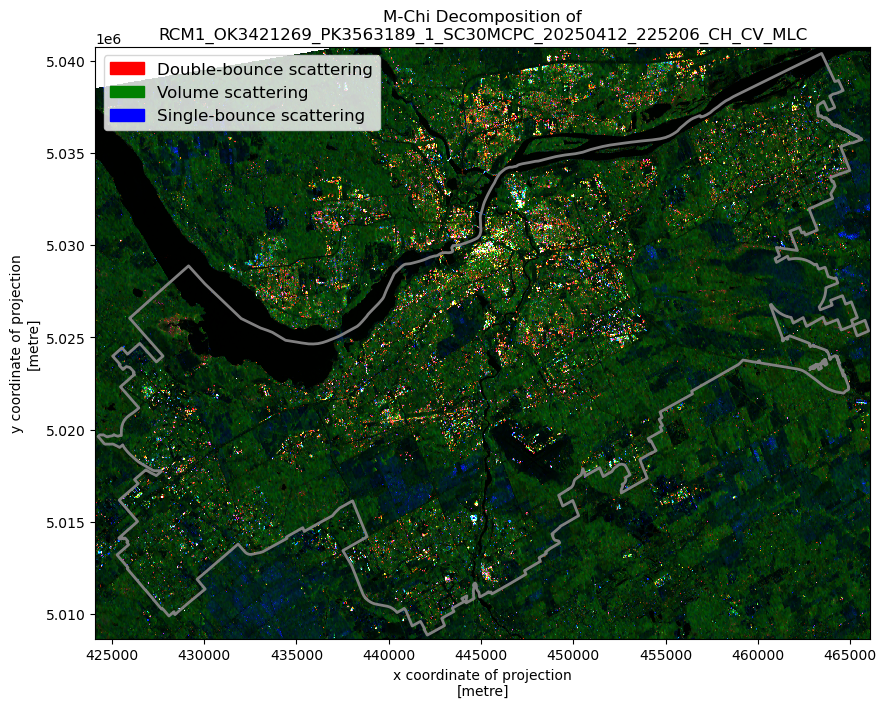

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

mchi_stack.plot.imshow(rgb='band', ax=ax)
ax.set(title=f'M-Chi Decomposition of\n{order_key}')

legend = zip(['red', 'green', 'blue'], mchi_stack.attrs['long_name'])
patches = [mpatches.Patch(color=color, label=label) for color, label in legend]
ax.legend(handles=patches, loc='upper left', fontsize=12)

aoi_gdf.to_crs(mchi_stack.rio.crs.to_epsg()).plot(ax=ax, facecolor='none', edgecolor='gray', linewidth=2)

In [16]:
# Export all components as multiband GTiff
out_mchi = fr'./data/{order_key}_mchi.tif'
if not os.path.exists('./data'):
    os.mkdir('./data')
    
mchi_stack.rio.to_raster(out_mchi)

In [17]:
# Save individual scattering components named to match conventions from EODMS SAR Toolbox
components = ['dbl', 'vol', 'surf']
for i, component in enumerate(components):
    mchi_comp = mchi_stack[i]
    mchi_comp.attrs['long_name'] = [mchi_stack.attrs['long_name'][i]]
    mchi_comp.rio.to_raster(f'./data/{order_key}_mchi_{component}.tif')